## Model Diagnostics

In [1]:
import pandas as pd

housing = pd.read_csv('data/housing_renamed.csv')

In [2]:
housing.head()

,neighborhood,type,units,year_built,sq_ft,income,income_per_sq_ft,expense,expense_per_sq_ft,net_income,value,value_per_sq_ft,boro
0,FINANCIAL,R9-CONDOMINIUM,42,1920.0,36500,1332615,36.51,342005,9.37,990610,7300000,200.00,Manhattan
1,FINANCIAL,R4-CONDOMINIUM,78,1985.0,126420,6633257,52.47,1762295,13.94,4870962,30690000,242.76,Manhattan
2,FINANCIAL,RR-CONDOMINIUM,500,NaN,554174,17310000,31.24,3543000,6.39,13767000,90970000,164.15,Manhattan
3,FINANCIAL,R4-CONDOMINIUM,282,1930.0,249076,11776313,47.28,2784670,11.18,8991643,67556006,271.23,Manhattan
4,TRIBECA,R4-CONDOMINIUM,239,1985.0,219495,10004582,45.58,2783197,12.68,7221385,54320996,247.48,Manhattan


In [3]:
import statsmodels

import statsmodels.api as sm

import statsmodels.formula.api as smf

In [4]:
house1 = smf.glm('value_per_sq_ft ~ units + sq_ft + boro',

                  data=housing).fit()

print(house1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:        value_per_sq_ft   No. Observations:                 2626
Model:                            GLM   Df Residuals:                     2619
Model Family:                Gaussian   Df Model:                            6
Link Function:               identity   Scale:                          1879.5
Method:                          IRLS   Log-Likelihood:                -13621.
Date:                Sat, 30 Jul 2022   Deviance:                   4.9224e+06
Time:                        07:07:13   Pearson chi2:                 4.92e+06
No. Iterations:                     3   Pseudo R-squ. (CS):             0.7772
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                43.29

In [5]:
import seaborn as sns

import matplotlib.pyplot as plt

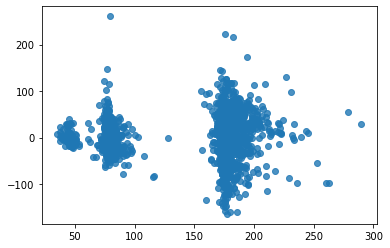

In [6]:
fig, ax = plt.subplots()

ax = sns.regplot(x=house1.fittedvalues,

            y=house1.resid_deviance, fit_reg=False)

plt.show()

In [7]:
fig.savefig('resid_1')

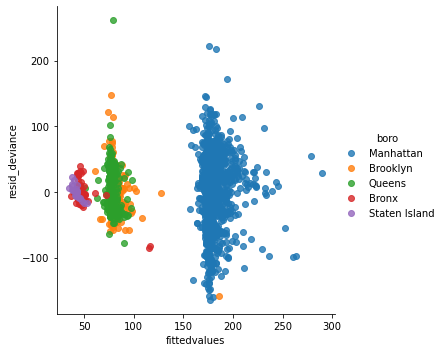

In [8]:
res_df = pd.DataFrame({

     'fittedvalues': house1.fittedvalues,

     'resid_deviance': house1.resid_deviance,

     'boro': housing['boro']

})


fig = sns.lmplot(x='fittedvalues', y='resid_deviance',

                data=res_df, hue='boro', fit_reg=False)

plt.show()


In [9]:
fig.savefig('resid_boros')

In [10]:
from scipy import stats

In [11]:
resid = house1.resid_deviance.copy()

resid_std = stats.zscore(resid)

In [12]:
housing.dtypes

neighborhood          object
type                  object
units                  int64
year_built           float64
sq_ft                  int64
income                 int64
income_per_sq_ft     float64
expense                int64
expense_per_sq_ft    float64
net_income             int64
value                  int64
value_per_sq_ft      float64
boro                  object
dtype: object

In [13]:
# the original housing data set has a column named class

# this would cause an error if we used 'class'

# because 'class' is a Python keyword

# the column was renamed to 'type'

f1 = 'value_per_sq_ft ~ units + sq_ft + boro'

f2 = 'value_per_sq_ft ~ units * sq_ft + boro'

f3 = 'value_per_sq_ft ~ units + sq_ft * boro + type'

f4 = 'value_per_sq_ft ~ units + sq_ft * boro + sq_ft * type'

f5 = 'value_per_sq_ft ~ boro + type'


house1 = smf.ols(f1, data=housing).fit()

house2 = smf.ols(f2, data=housing).fit()

house3 = smf.ols(f3, data=housing).fit()

house4 = smf.ols(f4, data=housing).fit()

house5 = smf.ols(f5, data=housing).fit()

In [14]:
mod_results = pd.concat([house1.params, house2.params, house3.params,

          house4.params, house5.params], axis=1).rename(columns=lambda x: 'house' + 
str(x + 1)).reset_index().rename(columns={'index': 'param'}).melt(id_vars='param', var_name='model', value_name='estimate')



print(mod_results.head())

                   param   model    estimate
0              Intercept  house1   43.290863
1       boro[T.Brooklyn]  house1   34.562150
2      boro[T.Manhattan]  house1  130.992363
3         boro[T.Queens]  house1   32.993674
4  boro[T.Staten Island]  house1   -3.630251


In [15]:
model_names = ['house1', 'house2', 'house3', 'house4', 'house5']

house_anova = statsmodels.stats.anova.anova_lm(

    house1, house2, house3, house4, house5)

house_anova.index = model_names

print(house_anova)

        df_resid           ssr  df_diff        ss_diff          F  \
house1    2619.0  4.922389e+06      0.0            NaN        NaN   
house2    2618.0  4.884872e+06      1.0   37517.437605  20.039049   
house3    2612.0  4.619926e+06      6.0  264945.539994  23.585728   
house4    2609.0  4.576671e+06      3.0   43255.441192   7.701289   
house5    2618.0  4.901463e+06     -9.0 -324791.847907  19.275539   

              Pr(>F)  
house1           NaN  
house2  7.912333e-06  
house3  2.754431e-27  
house4  4.025581e-05  
house5           NaN  


In [16]:
house_models = [house1, house2, house3, house4, house5]

In [17]:
house_aic = list(

    map(statsmodels.regression.linear_model.RegressionResults.aic,

       house_models))

house_bic = list(

    map(statsmodels.regression.linear_model.RegressionResults.bic,

       house_models))

# remember dicts are unordered

abic = pd.DataFrame({

    'model': model_names,

    'aic': house_aic,

    'bic': house_bic



})

TypeError: 'pandas._libs.properties.CachedProperty' object is not callable

In [ ]:
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression

In [ ]:
print(housing.columns)

In [ ]:
# get training and test data

X_train, X_test, y_train, y_test = train_test_split(

    pd.get_dummies(housing[['units', 'sq_ft', 'boro']],

                       drop_first=True),

    housing['value_per_sq_ft'],

    test_size=0.20,

    random_state=42

)

In [ ]:
lr = LinearRegression().fit(X_train, y_train)

print(lr.score(X_test, y_test))

In [ ]:
from sklearn.model_selection import KFold, cross_val_score



# get a fresh new housing data set

housing = pd.read_csv('data/housing_renamed.csv')

In [ ]:
kf = KFold(n_splits=5)


In [ ]:
y, X = dmatrices('value_per_sq_ft ~ units + sq_ft + boro', housing)

In [ ]:
model = LinearRegression()

scores = cross_val_score(model, X, y, cv=5)

print(scores)